# 과제1. 직원 이직 분석

* 회사 인사팀에서는 AIVLER 들에게 직원의 이직여부과 관련해서 분석을 요청하였습니다.
* 최근 이직율이 증가하는 것에 대해 우려를 갖고 있기에, 이직여부에 영향을 주는 요인에 대해 분석하여, 직원들이 회사를 떠나지 않도록 인사 프로그램을 준비하려고 합니다.
* 필요하다면, 검색을 통해 '직원이 회사를 떠나는 이유' 등을 찾아보는 것은 데이터 분석을 하는데 도움이 될 것입니다.
* 자, 이제 인사팀에서 제공한 데이터를 바탕으로 각각 개별 변수의 분포를 살펴보며, 비즈니스 인사이트를 최대한 도출해 봅시다.


![](https://adoptostaging.blob.core.windows.net/media/employee-attrition-reasons-9LIqMv.jpg)

## 0.환경설정

### 1) 라이브러리 로딩

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.mosaicplot import mosaic
from scipy import stats as spst
import statsmodels.api as sm

### 2) 데이터 로딩

In [6]:
# data data
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/Attrition_NA.CSV"
data = pd.read_csv(path)
data.drop(['EducationField', 'Education','JobInvolvement', 'StockOptionLevel', 'BusinessTravel','YearsWithCurrManager'
,'YearsInCurrentRole','JobRole', 'Department','EmployeeNumber','EnvironmentSatisfaction','TrainingTimesLastYear','YearsAtCompany']
          , axis = 1, inplace = True)
data['Attrition'] = np.where(data['Attrition']=='Yes', 1, 0)
data.head(10)

,Attrition,Age,DistanceFromHome,Gender,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,RelationshipSatisfaction,TotalWorkingYears,WorkLifeBalance
0,0,33,7.0,Male,3,Married,11691,0.0,No,11,4,14,4
1,0,35,18.0,Male,4,Single,9362,2.0,No,11,3,10,3
2,0,42,6.0,Male,1,Married,13348,9.0,No,13,2,18,4
3,0,46,2.0,Female,1,Married,17048,8.0,No,23,1,28,3
4,0,39,NaN,Male,4,Divorced,4127,2.0,No,18,4,7,3
5,1,22,4.0,Male,3,Single,3894,5.0,No,16,3,4,3
6,0,24,21.0,Male,1,Divorced,2296,0.0,No,14,2,2,3
7,0,34,8.0,Male,3,Married,4404,2.0,No,12,1,6,4
8,0,30,20.0,Male,1,Married,9957,0.0,No,15,3,7,2
9,0,26,6.0,Female,4,Married,2659,1.0,Yes,13,3,3,3


In [8]:
data['YearIncome'] = data['MonthlyIncome'] * 12

,Attrition,Age,DistanceFromHome,Gender,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,RelationshipSatisfaction,TotalWorkingYears,WorkLifeBalance,YearIncome
0,0,33,7.0,Male,3,Married,11691,0.0,No,11,4,14,4,140292
1,0,35,18.0,Male,4,Single,9362,2.0,No,11,3,10,3,112344
2,0,42,6.0,Male,1,Married,13348,9.0,No,13,2,18,4,160176
3,0,46,2.0,Female,1,Married,17048,8.0,No,23,1,28,3,204576
4,0,39,NaN,Male,4,Divorced,4127,2.0,No,18,4,7,3,49524


In [11]:
data['Last_YI'] = data['YearIncome'] - (data['YearIncome'] * (data['PercentSalaryHike'] / 100))

|	구분	|	변수 명	|	내용	|	type	|	비고	|
|	----	|	----	|	----	|	----	|	----	|
|	**Target**	|	**Attrition**	|	이직여부, Yes , No	|	범주	| 1- 이직, 0- 잔류		|
|	feature	|	Age	|	나이	|	숫자	|		|
|	feature	|	DistanceFromHome	|	집-직장 거리	|	숫자	|	마일	|
|	feature	|	Gender	|	성별	|	범주	| Male, Female		|
|	feature	|	JobSatisfaction	|	직무 만족도	|	범주	|	1 Low, 2 Medium, 3 High, 4 Very High	|
|	feature	|	MaritalStatus	|	결혼상태	|	범주	| Single, Married, Divorced		|
|	feature	|	MonthlyIncome	|	월급	|	숫자	| 달러	|
|	feature	|	NumCompaniesWorked	|	입사 전 근무한 회사 수	|	숫자	|	0 - 우리회사가 첫 직장	|
|	feature	|	RelationshipSatisfaction	|	동료와의 관계	|	범주	| 1 Low, 2 Medium, 3 High, 4 Very High		|
|	feature	|	OverTime	|	야근여부	|	범주	|	Yes, No	|
|	feature	|	PercentSalaryHike	|	전년대비 급여인상율	|	숫자	|	%	|
|	feature	|	TotalWorkingYears	|	총 경력 연수	|	숫자	|		|
|	feature	|	WorkLifeBalance	|	워라밸. 일-삶 균형도	|	범주	|	1 Bad, 2 Good, 3 Better, 4 Best	|

In [13]:
data['Last_MI'] = data ['Last_YI'] /12


,Attrition,Age,DistanceFromHome,Gender,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,RelationshipSatisfaction,TotalWorkingYears,WorkLifeBalance,YearIncome,Last_YI,Last_MI
0,0,33,7.0,Male,3,Married,11691,0.0,No,11,4,14,4,140292,124859.88,10404.99
1,0,35,18.0,Male,4,Single,9362,2.0,No,11,3,10,3,112344,99986.16,8332.18
2,0,42,6.0,Male,1,Married,13348,9.0,No,13,2,18,4,160176,139353.12,11612.76
3,0,46,2.0,Female,1,Married,17048,8.0,No,23,1,28,3,204576,157523.52,13126.96
4,0,39,NaN,Male,4,Divorced,4127,2.0,No,18,4,7,3,49524,40609.68,3384.14


In [15]:
data['Diff_Income'] = data['MonthlyIncome'] - data['Last_MI']
data.head()

,Attrition,Age,DistanceFromHome,Gender,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,RelationshipSatisfaction,TotalWorkingYears,WorkLifeBalance,YearIncome,Last_YI,Last_MI,Diff_Income
0,0,33,7.0,Male,3,Married,11691,0.0,No,11,4,14,4,140292,124859.88,10404.99,1286.01
1,0,35,18.0,Male,4,Single,9362,2.0,No,11,3,10,3,112344,99986.16,8332.18,1029.82
2,0,42,6.0,Male,1,Married,13348,9.0,No,13,2,18,4,160176,139353.12,11612.76,1735.24
3,0,46,2.0,Female,1,Married,17048,8.0,No,23,1,28,3,204576,157523.52,13126.96,3921.04
4,0,39,NaN,Male,4,Divorced,4127,2.0,No,18,4,7,3,49524,40609.68,3384.14,742.86


----

## 1.가설수립

* 여기서는 가설을 생략합니다.

----

## 2.단변량 분석

① 변수의 비즈니스 의미  

② 숫자? 범주?  

③ NaN 존재 여부 및 조치 방안  

④ 기초통계량  

⑤ 분포  

⑥ 위 정보로부터 파악한 내용(비즈니스!) 정리  

⑦ 추가 분석해볼 사항 도출

## 3.이변량 분석 
* 자료의 종류에 맞게 X --> Y 에 대해서 그래프(시각화)와 가설검정(수치화)를 수행하고 결과를 평가합니다.
* 가설검정시 다음의 항목을 참조하여 수행합니다.
    * 유의수준 : 5%
    * 숫자 --> 숫자 : 상관분석
    * 범주 --> 범주 : 카이제곱검정
    * 범주 --> 숫자 : t검정, 분산분석
    * 숫자 --> 범주 : 로지스틱 회귀모형을 통해, 회귀계수의 P.value로 검정을 수행합니다.
* (옵션)자료에 대한 가정 검정.(정규성, 등분산성 등)

### (1) 범주형 Feature --> Target
* 모든 범주형 Feature에 대해서 Y와 비교하여 차트를 그리고 수치화 하시오.  
    ① 교차표(pd.crosstab())  
    ② 시각화( Stacked Bar, Mosaic)  
    ③ 가설검정(카이제곱검정)
* 각 feature 별로 관계의 정도를 3가지로 정리해봅시다. 

#### 1) Gender --> Attrtion

① 교차표(pd.crosstab())

In [4]:
pd.crosstab(data['Attrition'], data['Gender'], normalize='columns')

Gender,Female,Male
Attrition,,
0,0.859184,0.827632
1,0.140816,0.172368


② 시각화( Stacked Bar, Mosaic)

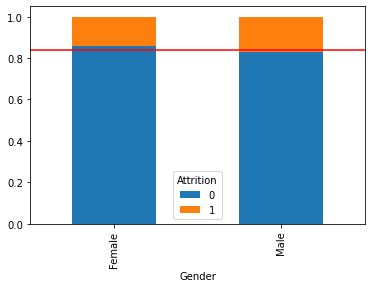

In [15]:
temp = pd.crosstab(data['Gender'], data['Attrition'], normalize = 'index')
temp.plot.bar(stacked=True)
plt.axhline(1-data['Attrition'].mean(), color = 'r')
plt.show()

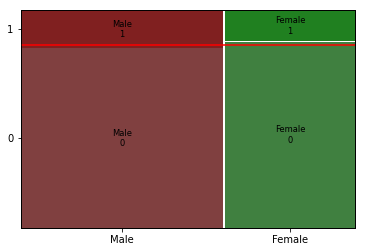

In [10]:
mosaic(data, [ 'Gender','Attrition'])
plt.axhline(1- data['Attrition'].mean(), color = 'r')
plt.show()

시각화를 통해 파악한 내용을 적어 봅시다.

In [ ]:
여자와 남자의 이직률이 전체의 평균에 거의 일치하므로 관계가 없는걸로 보인다.

③ 가설검정(카이제곱검정)

In [11]:
# 먼저 집계
table = pd.crosstab(data['Attrition'], data['Gender'])
print('교차표\n', table)
print('-' * 100)

# 카이제곱검정
result = spst.chi2_contingency(table)
print('카이제곱통계량', result[0])
print('p-value', result[1])
print('기대빈도\n',result[3])

교차표
 Gender     Female  Male
Attrition              
0             421   629
1              69   131
----------------------------------------------------------------------------------------------------
카이제곱통계량 1.9782495940105371
p-value 0.15957492990528155
기대빈도
 [[411.6 638.4]
 [ 78.4 121.6]]


④ 시각화와 가설검정을 통해서 파악한 내용을 적어 봅시다.

* Gender의 범주 2개, Attrition의 범주 2개 이므로 자유도는 (2-1) * (2-1) = 1 이다. 
* 하지만 카이제곱 통계량이 자유도의 2~3배인 2~3 보다 1.9가 작으므로 차이가 거의 없다고 볼 수 있다.
* 또한 pvalue의 값이 0.05보다 크므로 이것 또한 Gender와 이직률은 거의 관계가 없다고 볼 수 있다.

#### 2) MaritalStatus --> Attrtion

① 교차표(pd.crosstab())

In [12]:
pd.crosstab(data['Attrition'], data['MaritalStatus'], normalize='columns')

MaritalStatus,Divorced,Married,Single
Attrition,,,
0,0.916667,0.878947,0.732673
1,0.083333,0.121053,0.267327


② 시각화( Stacked Bar, Mosaic)

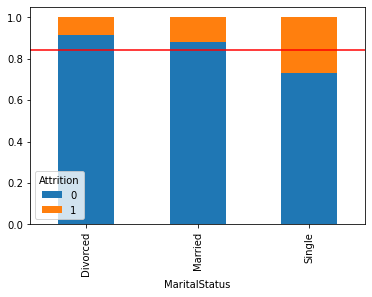

In [16]:
temp = pd.crosstab(data['MaritalStatus'], data['Attrition'], normalize = 'index')
temp.plot.bar(stacked=True)
plt.axhline(1-data['Attrition'].mean(), color = 'r')
plt.show()

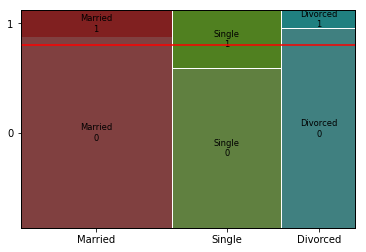

In [14]:
mosaic(data, [ 'MaritalStatus','Attrition'])
plt.axhline(1- data['Attrition'].mean(), color = 'r')
plt.show()

시각화를 통해 파악한 내용을 적어 봅시다.

* 각 범주 마다 값들이 평균과 비슷하지 않기 때문에 관계가 있는 것으로 보인다.

③ 가설검정(카이제곱검정)

In [17]:
# 먼저 집계
table = pd.crosstab(data['Attrition'], data['MaritalStatus'])
print('교차표\n', table)
print('-' * 100)

# 카이제곱검정
result = spst.chi2_contingency(table)
print('카이제곱통계량', result[0])
print('p-value', result[1])
print('기대빈도\n',result[3])

교차표
 MaritalStatus  Divorced  Married  Single
Attrition                               
0                   253      501     296
1                    23       69     108
----------------------------------------------------------------------------------------------------
카이제곱통계량 53.12935546374186
p-value 2.9047385436211595e-12
기대빈도
 [[231.84 478.8  339.36]
 [ 44.16  91.2   64.64]]


④ 시각화와 가설검정을 통해서 파악한 내용을 적어 봅시다.

* 자유도는 2 이므로 2 ~ 3배인 4~ 6보다 카이제곱 통계량이 큰 것으로 보아 관계가 있는 걸로 판단 됨.
* 또한 pvalue 또한 0.05보다 한참 작으므로 관계가 있다고 판단됨.

#### 3) JobSatisfaction --> Attrtion

① 교차표(pd.crosstab())

In [18]:
pd.crosstab(data['Attrition'], data['JobSatisfaction'], normalize='columns')

JobSatisfaction,1,2,3,4
Attrition,,,,
0,0.788,0.834043,0.836957,0.879093
1,0.212,0.165957,0.163043,0.120907


② 시각화( Stacked Bar, Mosaic)

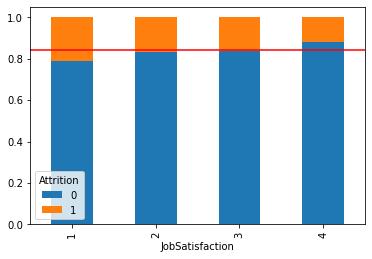

In [19]:
temp = pd.crosstab(data['JobSatisfaction'], data['Attrition'], normalize = 'index')
temp.plot.bar(stacked=True)
plt.axhline(1-data['Attrition'].mean(), color = 'r')
plt.show()

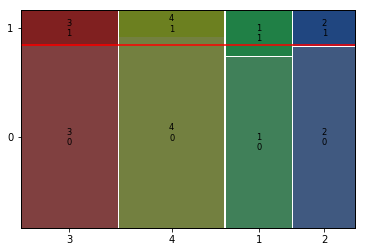

In [20]:
mosaic(data, [ 'JobSatisfaction','Attrition'])
plt.axhline(1- data['Attrition'].mean(), color = 'r')
plt.show()

시각화를 통해 파악한 내용을 적어 봅시다.

* 만족도 2,3은 평균과 거의 일치 하지만 1, 4에 이직률의 차이가 있으므로 더 분석해볼 필요가 있음

③ 가설검정(카이제곱검정)

In [21]:
# 먼저 집계
table = pd.crosstab(data['Attrition'], data['JobSatisfaction'])
print('교차표\n', table)
print('-' * 100)

# 카이제곱검정
result = spst.chi2_contingency(table)
print('카이제곱통계량', result[0])
print('p-value', result[1])
print('기대빈도\n',result[3])

교차표
 JobSatisfaction    1    2    3    4
Attrition                          
0                197  196  308  349
1                 53   39   60   48
----------------------------------------------------------------------------------------------------
카이제곱통계량 9.63151465436614
p-value 0.021972649369306214
기대빈도
 [[210.   197.4  309.12 333.48]
 [ 40.    37.6   58.88  63.52]]


④ 시각화와 가설검정을 통해서 파악한 내용을 적어 봅시다.

* 일단 자유도는 3이므로 2~3배인 6~9보다는 약간 높은 카이제곱 통계량을 가지고 있으나 결혼상태 보다는 적은 관계를 가지고 있는 것으로 판단됨.
* pvalue의 경우에도 0.05보다는 작지만 크게 차이가 안나는 것으로 보아 관계는 있으나 약한 관계에 있다고 판단됨.

#### 4) 추가 --> Attrtion

In [ ]:
OverTime

① 교차표(pd.crosstab())

In [48]:
pd.crosstab(data['Attrition'], data['OverTime'], normalize='columns')

OverTime,No,Yes
Attrition,,
0,0.896205,0.69774
1,0.103795,0.30226


② 시각화( Stacked Bar, Mosaic)

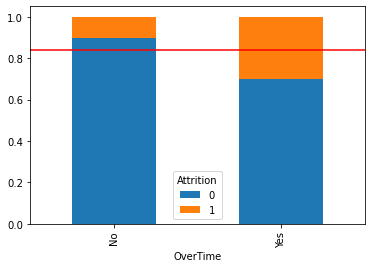

In [49]:
temp = pd.crosstab(data['OverTime'], data['Attrition'], normalize = 'index')
temp.plot.bar(stacked=True)
plt.axhline(1-data['Attrition'].mean(), color = 'r')
plt.show()

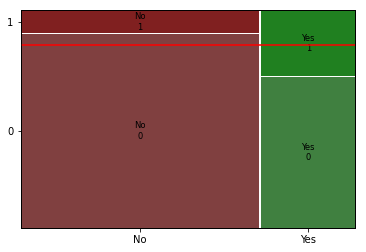

In [50]:
mosaic(data, [ 'OverTime','Attrition'])
plt.axhline(1- data['Attrition'].mean(), color = 'r')
plt.show()

시각화를 통해 파악한 내용을 적어 봅시다.

* 야근이 많을수록 이직률이 올라가는 것을 볼 수 있음

③ 가설검정(카이제곱검정)

In [51]:
# 먼저 집계
table = pd.crosstab(data['Attrition'], data['OverTime'])
print('교차표\n', table)
print('-' * 100)

# 카이제곱검정
result = spst.chi2_contingency(table)
print('카이제곱통계량', result[0])
print('p-value', result[1])
print('기대빈도\n',result[3])

교차표
 OverTime    No  Yes
Attrition          
0          803  247
1           93  107
----------------------------------------------------------------------------------------------------
카이제곱통계량 72.89605419432075
p-value 1.366611233098835e-17
기대빈도
 [[752.64 297.36]
 [143.36  56.64]]


④ 시각화와 가설검정을 통해서 파악한 내용을 적어 봅시다.

* pvalue도 0.05보다 낮고 자유도가 1의 2~3배인 2~3보다 훨씬 높은 카이제곱통계량을 가지고 있으므로 강한 관계를 가지고 있는 것으로 보임

#### 5) 추가 --> Attrtion

① 교차표(pd.crosstab())

② 시각화( Stacked Bar, Mosaic)

시각화를 통해 파악한 내용을 적어 봅시다.

③ 가설검정(카이제곱검정)

④ 시각화와 가설검정을 통해서 파악한 내용을 적어 봅시다.

### (2) 숫자형 Feature --> target

* 숫자형 Feature에 대해서 Y와 비교하여 차트를 그리고 수치화 하시오.  
    ① 그래프 : histogram, densityplot   
    ② 수치화 : 로지스틱회귀

#### 1) Age --> Attrtion


① 그래프 : histogram, densityplot

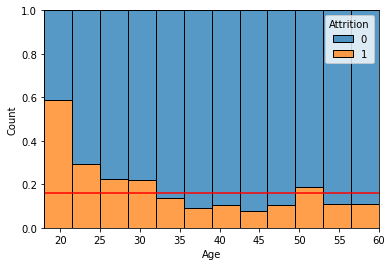

In [59]:
sns.histplot(x='Age', data = data, bins = 12
             , hue ='Attrition', multiple = 'fill')
# 나이가 60살까지 있는 것으로 보여 범주는 5살 단위롭 보기위해 범주를 12로 설정함
plt.axhline(data['Attrition'].mean(), color = 'r')
plt.show()

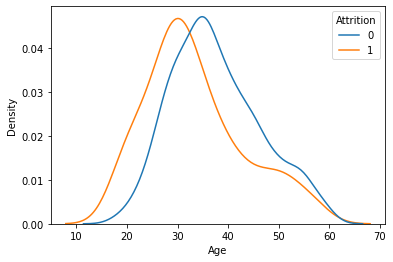

In [24]:
sns.kdeplot(x='Age', data = data, hue ='Attrition' , common_norm = False)
plt.show()

시각화를 통해 파악한 내용을 적어 봅시다.

* 그래프를 보면 18~33살 정도까지 평균보다 높은 이직률을 가지고 있음 (하지만 27세 쯤에는 이직하는 사람이 한명도 없을정도로 0에 가깝다. --> 조사 필요)
* 33살 부터는 이직률이 꾸준히 감소하였지만 40대 후반부터는 예외도 있지만 조금씩 이직률이 증가하는 추세를 보임

② 수치화 : 로지스틱회귀

In [25]:
temp = data.loc[data['Age'].notnull()]

model = sm.Logit(temp['Attrition'], temp['Age'])
result = model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.424660
         Iterations 5
Age    4.667821e-100
dtype: float64


③ 시각화와 수치화를 통해 파악한 내용을 적어 봅시다.

* Age의 pvalue 값은 0에 수렴할 만큼 0.05 보다 작으므로 관계는 있는것으로 보임
* 그래프로 보았을때 20대의 이직률과 40대의 이직률의 차이가 큰 것으로 보아 관계가 꽤 큰 것으로 보임

#### 2) DistanceFromHome --> Attrtion


① 그래프 : histogram, densityplot

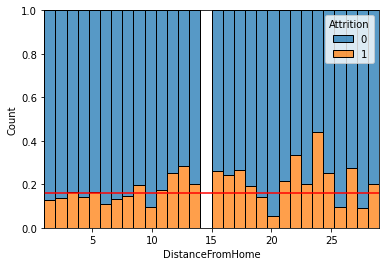

In [39]:
sns.histplot(x='DistanceFromHome', data = data, bins = 30
             , hue ='Attrition', multiple = 'fill')
plt.axhline(data['Attrition'].mean(), color = 'r')
plt.show()

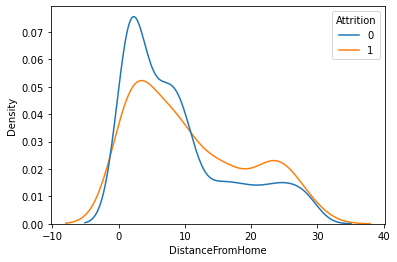

In [27]:
sns.kdeplot(x='DistanceFromHome', data = data, hue ='Attrition' , common_norm = False)
plt.show()

시각화를 통해 파악한 내용을 적어 봅시다.

* 0 에서 15 전까지는 평균에 가깝게 수치가 나타남
* 하지만 15마일 이후부터는 들쭉날쭉한 수치가 나타남

② 수치화 : 로지스틱회귀

In [40]:
temp = data.loc[data['DistanceFromHome'].notnull()]

model = sm.Logit(temp['Attrition'], temp['DistanceFromHome'])
result = model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.568793
         Iterations 6
DistanceFromHome    2.694280e-44
dtype: float64


③ 시각화와 수치화를 통해 파악한 내용을 적어 봅시다.

* pvalue의 값이 0.05보다 작아서 관계가 있는걸로 보임
* 하지만 그래프를 보면 관계가 강해보이지만 나이보다는 덜 관계가 있다고 판단됨

#### 3) MonthlyIncome --> Attrtion


① 그래프 : histogram, densityplot

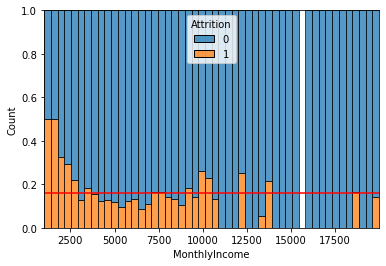

In [42]:
sns.histplot(x='MonthlyIncome', data = data, bins = 50
             , hue ='Attrition', multiple = 'fill')
plt.axhline(data['Attrition'].mean(), color = 'r')
plt.show()

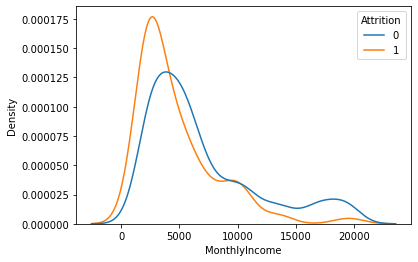

In [33]:
sns.kdeplot(x='MonthlyIncome', data = data, hue ='Attrition' , common_norm = False)
plt.show()

시각화를 통해 파악한 내용을 적어 봅시다.

* 임금이 5000전 까지는 임금이 높아질 수록 이직률이 낮아지는 것으로 보임
* 5000 부터 10,000 까지는 임금이 높아질 수록 이직률이 높아지는 것으로 보임
* 그 이후엔 이직을 안하는 사람도 있고 들쭉날쭉한 수치를 보임

② 수치화 : 로지스틱회귀

In [41]:
temp = data.loc[data['MonthlyIncome'].notnull()]

model = sm.Logit(temp['Attrition'], temp['MonthlyIncome'])
result = model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.437401
         Iterations 6
MonthlyIncome    1.922717e-71
dtype: float64


③ 시각화와 수치화를 통해 파악한 내용을 적어 봅시다.

* pvalue 값이 0.05보다 작으므로 관계가 있는 것으로 보임
* 그래프를 보면 DistanceFromHome 보단 강한 관계를 가지고 있는것으로 보이나 Age 보다는 약한 관계가 있는 것을  보임

#### 4) 작년대비 월급과 비교하여 이직률 확인


① 그래프 : histogram, densityplot

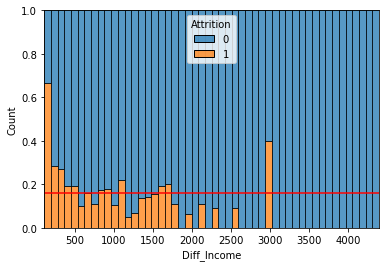

In [16]:
sns.histplot(x='Diff_Income', data = data, bins = 50
             , hue ='Attrition', multiple = 'fill')
plt.axhline(data['Attrition'].mean(), color = 'r')
plt.show()

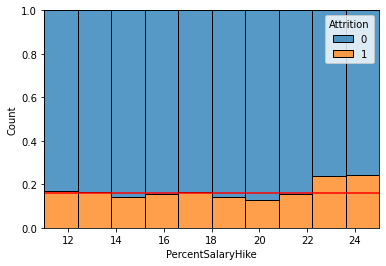

In [28]:
sns.histplot(x='PercentSalaryHike', data = data, bins = 10
             , hue ='Attrition', multiple = 'fill')
plt.axhline(data['Attrition'].mean(), color = 'r')
plt.show()

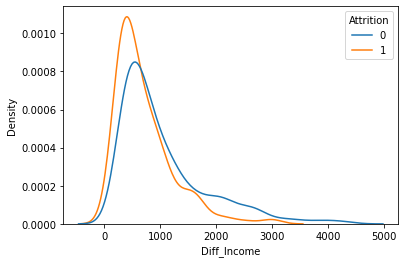

In [17]:
sns.kdeplot(x='Diff_Income', data = data, hue ='Attrition' , common_norm = False)
plt.show()

In [31]:
data['MonthlyIncome'].describe()

count     1250.000000
mean      6525.548000
std       4676.979554
min       1009.000000
25%       2932.250000
50%       4988.000000
75%       8437.500000
max      19999.000000
Name: MonthlyIncome, dtype: float64

시각화를 통해 파악한 내용을 적어 봅시다.

* 작년대비 월급 인상금액이 적을수록 이직을 많이 하는 것으로 보임
* 하지만 3000달러 정도 월급액이 인상된 사람의 이직률이 있는 것은 확인이 필요함

In [26]:
data2 = data.loc[data['Diff_Income'] > 2500]
data3 = data2.loc[data['Attrition'] == 1]
data3

,Attrition,Age,DistanceFromHome,Gender,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,RelationshipSatisfaction,TotalWorkingYears,WorkLifeBalance,YearIncome,Last_YI,Last_MI,Diff_Income
533,1,52,2.0,Female,4,Married,19845,1.0,No,15,4,33,3,238140,202419.00,16868.25,2976.75
555,1,55,2.0,Male,1,Married,19859,5.0,Yes,13,4,24,3,238308,207327.96,17277.33,2581.67
974,1,45,2.0,Female,2,Single,18824,2.0,Yes,16,1,26,3,225888,189745.92,15812.16,3011.84


* 작년대비해서 월급이 2500달러 이상 오른 사람들 중 이직을 한 사람을 살펴 본 결과 나이가 40 50대 이고, 다른 사람들에 비해 연봉 인상률이 적은 사람인 것으로 알 수 있음

② 수치화 : 로지스틱회귀

In [18]:
temp = data.loc[data['Diff_Income'].notnull()]

model = sm.Logit(temp['Attrition'], temp['Diff_Income'])
result = model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.440661
         Iterations 6
Diff_Income    4.172622e-70
dtype: float64


③ 시각화와 수치화를 통해 파악한 내용을 적어 봅시다.

> 

#### 5) 추가 --> Attrtion


① 그래프 : histogram, densityplot

시각화를 통해 파악한 내용을 적어 봅시다.

> 

② 수치화 : 로지스틱회귀

③ 시각화와 수치화를 통해 파악한 내용을 적어 봅시다.

> 

## 4.관계 정리

### 1) 강한관계의 변수

* MaritalStatus
* Age
* DistanceFromHome
* MonthlyIncome

### 2) 중간관계의 변수

* JobSatisfaction 

### 3) (거의)관계 없음

* Gender

## 5. 추가 분석

### 1) 분석1

* MonthlyIncome을 5,000 ,10,000으로 나누어 분석해볼 필요가 있어보임.

In [45]:
bins = [0, 5000, 10000, np.inf]
labels = ['0_5000', '5000_10000', '10000_']
data['Income_Group'] = pd.cut(data['MonthlyIncome'], bins = bins , labels = labels
                               , right = False)
data.head()

,Attrition,Age,DistanceFromHome,Gender,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,RelationshipSatisfaction,TotalWorkingYears,WorkLifeBalance,Income_Group
0,0,33,7.0,Male,3,Married,11691,0.0,No,11,4,14,4,10000_
1,0,35,18.0,Male,4,Single,9362,2.0,No,11,3,10,3,5000_10000
2,0,42,6.0,Male,1,Married,13348,9.0,No,13,2,18,4,10000_
3,0,46,2.0,Female,1,Married,17048,8.0,No,23,1,28,3,10000_
4,0,39,NaN,Male,4,Divorced,4127,2.0,No,18,4,7,3,0_5000


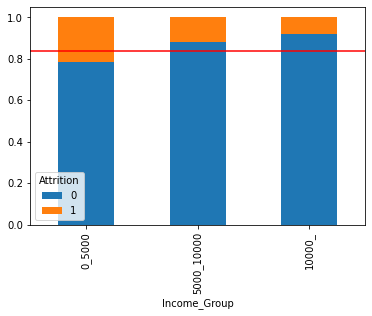

카이제곱통계량 32.22810607229246
p-value 1.0040507972017162e-07


In [46]:
temp = pd.crosstab(data['Income_Group'], data['Attrition'], normalize = 'index')
temp.plot.bar(stacked=True)
plt.axhline(1-data['Attrition'].mean(), color = 'r')
plt.show()

table = pd.crosstab(data['Attrition'], data['Income_Group'])
result = spst.chi2_contingency(table)
print('카이제곱통계량', result[0])
print('p-value', result[1])

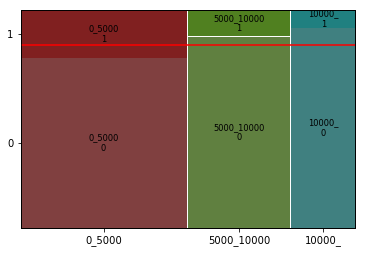

In [47]:
mosaic(data, [ 'Income_Group','Attrition'])
plt.axhline(1- data['Attrition'].mean(), color = 'r')
plt.show()

* 그래프를 보니 MonthlyIncome이 증가할수록 이직률도 높아지는 것으로 알 수 있음!!!!

### 2) 분석2

### 3) 분석3

### 4) 분석4